In [1]:
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/grand-xray-slam-division-b/train2.csv")
sample_submission = pd.read_csv("/kaggle/input/grand-xray-slam-division-b/sample_submission_2.csv")

In [3]:
train.head()

,Image_name,Patient_ID,Study,Sex,Age,ViewCategory,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,00000003_001_001.jpg,3,1,Male,41.0,Frontal,AP,0,1,0,...,1,0,0,1,0,0,0,0,0,0
1,00000004_001_001.jpg,4,1,Female,20.0,Frontal,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,00000004_001_002.jpg,4,1,Female,20.0,Lateral,Lateral,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,00000006_001_001.jpg,6,1,Female,42.0,Frontal,AP,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,00000010_001_001.jpg,10,1,Female,50.0,Frontal,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,0


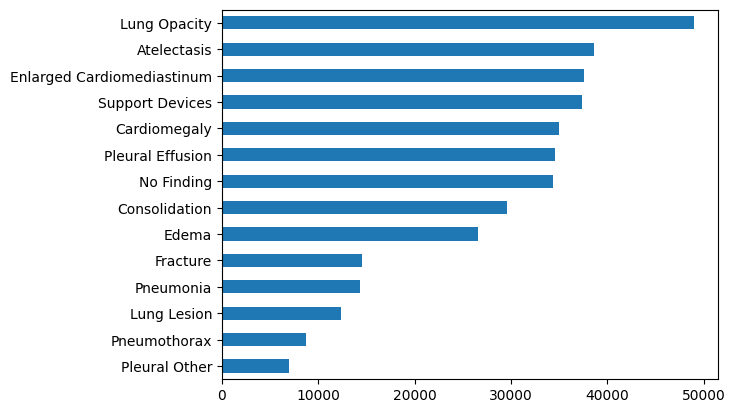

In [4]:
label_cols = [
    'Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum',
    'Fracture','Lung Lesion','Lung Opacity','No Finding','Pleural Effusion',
    'Pleural Other','Pneumonia','Pneumothorax','Support Devices'
]

train[label_cols].sum().sort_values().plot(kind='barh')
plt.show()


In [5]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Sex'] = train['Sex'].fillna('Unknown')
train[label_cols]=train[label_cols].fillna(0)

In [6]:
# class CheXpertDataset(Dataset):
#     """Custom PyTorch dataset for the CheXpert dataset."""
#     def __init__(self, csv_file, root_dir, transform=None):
#         """
#         Args:
#             csv_file (string): Path to the csv file with annotations.
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.df = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#         # Define the 14 pathology columns you are training on
#         self.pathology_columns = label_cols

#         # Fill NaNs with 0 (absent)
#         self.df[self.pathology_columns] = self.df[self.pathology_columns].fillna(0)

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         # Construct full image path
#         img_path = f"{self.root_dir}/{self.df.iloc[idx, 0]}"

#         # Open image and convert to RGB (to match ImageNet's 3 channels)
#         image = Image.open(img_path).convert('RGB')

#         # Get labels for the 14 pathologies
#         labels = torch.FloatTensor(self.df.iloc[idx, 7:].values.astype(float))

#         if self.transform:
#             image = self.transform(image)

#         return image, labels

In [7]:
def load_dataset(csv_file, root_dir):
    df = pd.read_csv(csv_file)
    df[label_cols] = df[label_cols].fillna(0)
    df["Image_Path"] = df["Image_name"].apply(lambda x: os.path.join(root_dir, x))
    return df

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert("RGB")
    if transform:
        image = transform(image)
    return image

def get_sample(df, idx, transform=None):
    img_path = df.iloc[idx]["Image_Path"]
    labels = torch.FloatTensor(df.iloc[idx][label_cols].values.astype(float))
    image = load_image(img_path, transform)
    return image, labels

def get_dataset(df, transform=None):
    """Return a callable-like dataset using closure behavior."""
    def _getitem(idx):
        return get_sample(df, idx, transform)
    return _getitem, len(df)

In [8]:
def apply_clahe(img):
    img_np = np.array(img)
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(img_clahe)

class CLAHETransform:
    def __call__(self, img):
        return apply_clahe(img)
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    CLAHETransform(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    normalize
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [9]:
def get_model():
    model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

    num_ftrs = model.classifier.in_features

    model.classifier = torch.nn.Linear(num_ftrs, 14)

    return model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# def run_kfold_cv(full_csv_path, image_root_dir, n_splits=5, num_epochs=5, batch_size=16, learning_rate=0.0001):
#     """Main function to run the K-Fold Cross-Validation pipeline."""

#     # Set device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # Load the full dataset
#     full_dataset = CheXpertDataset(csv_file=full_csv_path, root_dir=image_root_dir, transform=train_transform)
#     # Note: We create a separate dataset object for validation with val_transform
#     val_dataset_template = CheXpertDataset(csv_file=full_csv_path, root_dir=image_root_dir, transform=val_transform)


#     # Initialize K-Fold
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     fold_results = []

#     # --- K-Fold Loop ---
#     for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
#         print(f"\n{'='*20} FOLD {fold+1}/{n_splits} {'='*20}")

#         # Create subsets for training and validation for the current fold
#         train_subset = Subset(full_dataset, train_idx)
#         val_subset = Subset(val_dataset_template, val_idx)

#         # Create DataLoaders for the current fold
#         train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
#         val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

#         # Re-initialize the model for each fold to train from scratch
#         model = get_model().to(device)
#         criterion = torch.nn.BCEWithLogitsLoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

#         best_val_auc = 0.0

#         # --- Training & Validation for the current fold ---
#         for epoch in range(num_epochs):
#             # (The inner training and validation loops are the same as before)
#             model.train()
#             running_loss = 0.0
#             for inputs, labels in train_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss.item() * inputs.size(0)
#             epoch_loss = running_loss / len(train_loader.dataset)

#             model.eval()
#             val_loss = 0.0
#             all_labels, all_outputs = [], []
#             with torch.no_grad():
#                 for inputs, labels in val_loader:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item() * inputs.size(0)
#                     all_labels.append(labels.cpu().numpy())
#                     all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

#             epoch_val_loss = val_loss / len(val_loader.dataset)
#             all_labels = np.concatenate(all_labels)
#             all_outputs = np.concatenate(all_outputs)
#             val_auc = roc_auc_score(all_labels, all_outputs, average='macro', multi_class='ovo')

#             print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val AUC: {val_auc:.4f}")
#             scheduler.step(epoch_val_loss)

#             if val_auc > best_val_auc:
#                 best_val_auc = val_auc
#                 # Save the best model for this specific fold
#                 torch.save(model.state_dict(), f'chexnet_model_fold_{fold+1}.pth')

#         fold_results.append(best_val_auc)
#         print(f"Best validation AUC for Fold {fold+1}: {best_val_auc:.4f}")

#     # --- Final Results ---
#     mean_auc = np.mean(fold_results)
#     std_auc = np.std(fold_results)
#     print(f"\n{'='*50}")
#     print(f"K-Fold Cross-Validation Finished.")
#     print(f"Average AUC over {n_splits} folds: {mean_auc:.4f} ± {std_auc:.4f}")
#     print(f"{'='*50}")

In [12]:
def train_one_fold(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, fold):
    best_val_auc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        all_labels, all_outputs = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.cpu().numpy())
                all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        try:
            val_auc = roc_auc_score(all_labels, all_outputs, average='macro')
        except ValueError:
            val_auc = 0.0

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val AUC: {val_auc:.4f}")
        scheduler.step(epoch_val_loss)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), f"chexnet_fold_{fold+1}.pth")

    print(f"Best AUC for Fold {fold+1}: {best_val_auc:.4f}")
    return best_val_auc

def run_kfold_cv(full_csv_path, image_root_dir, get_model, train_transform, val_transform,
                 n_splits=5, num_epochs=5, batch_size=16, learning_rate=1e-4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df = load_dataset(full_csv_path, image_root_dir)
    fold_results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n{'='*20} FOLD {fold+1}/{n_splits} {'='*20}")

        # Get callable dataset functions
        train_getitem, _ = get_dataset(df.iloc[train_idx], transform=train_transform)
        val_getitem, _ = get_dataset(df.iloc[val_idx], transform=val_transform)

        # Custom dataset wrapper using lambda-like Dataset
        class Wrapper(torch.utils.data.Dataset):
            def __init__(self, getter, idxs):
                self.getter = getter
                self.idxs = idxs
            def __len__(self): return len(self.idxs)
            def __getitem__(self, i): return self.getter(self.idxs[i])

        train_dataset = Wrapper(train_getitem, range(len(train_idx)))
        val_dataset = Wrapper(val_getitem, range(len(val_idx)))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        model = get_model().to(device)
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

        best_auc = train_one_fold(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, fold)
        fold_results.append(best_auc)

    mean_auc = np.mean(fold_results)
    std_auc = np.std(fold_results)
    print(f"\n{'='*50}")
    print(f"K-Fold Cross-Validation Finished.")
    print(f"Average AUC over {n_splits} folds: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"{'='*50}")

In [13]:
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import os

CSV_PATH = '/kaggle/input/grand-xray-slam-division-b/train2.csv'
IMAGE_DIR = '/kaggle/input/grand-xray-slam-division-b/train2' # The root folder for images
FINAL_CSV_PATH = '/kaggle/working/train2_cleaned.csv'
# ---------------------

images_to_remove = [
    '00043046_001_001.jpg',
    '00052495_001_001.jpg',
    '00056890_001_001.jpg'
]

print(f"Loading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
original_count = len(df)
print(f"Original number of entries: {original_count}")

is_in_removal_list = df['Image_name'].isin(images_to_remove)

final_df = df[~is_in_removal_list]
final_count = len(final_df)

print(f"\nRemoving {len(images_to_remove)} specified images...")
print(f"Number of entries after removal: {final_count}")
print(f"Total entries removed: {original_count - final_count}")

final_df.to_csv(FINAL_CSV_PATH, index=False)
print(f"\nFinal CSV saved to: {FINAL_CSV_PATH}")

# print(f"Loading CSV from: {CSV_PATH}")
# df = pd.read_csv(CSV_PATH)
# df['is_valid'] = True # Add a column to mark valid images

# print("Scanning images for corruption... This may take a while.")
# # Use tqdm for a nice progress bar
# for index, row in tqdm(df.iterrows(), total=df.shape[0]):
#     try:
#         img_path = os.path.join(IMAGE_DIR, row['Image_name'])
#         # Try to open the image file
#         with Image.open(img_path) as img:
#             # You can add more checks here, like img.verify(), but open() is usually enough
#             pass
#     except (IOError, UnidentifiedImageError) as e:
#         print(f"\nFound corrupt image, marking for removal: {row['Image_name']}")
#         # Mark the row corresponding to the corrupt image as invalid
#         df.at[index, 'is_valid'] = False

# # Filter the DataFrame to keep only the valid rows
# cleaned_df = df[df['is_valid'] == True].copy()
# # Drop the helper column
# cleaned_df.drop(columns=['is_valid'], inplace=True)

# print(f"\nOriginal entries: {len(df)}")
# print(f"Corrupt entries found: {len(df) - len(cleaned_df)}")
# print(f"Cleaned entries: {len(cleaned_df)}")

# # Save the new, cleaned CSV
# cleaned_df.to_csv(CLEANED_CSV_PATH, index=False)
# print(f"Cleaned CSV saved to: {CLEANED_CSV_PATH}")

Loading CSV from: /kaggle/input/grand-xray-slam-division-b/train2.csv
Original number of entries: 108494

Removing 3 specified images...
Number of entries after removal: 108491
Total entries removed: 3

Final CSV saved to: /kaggle/working/train2_cleaned.csv


In [14]:
# if __name__ == '__main__':
#     FULL_TRAIN_CSV = '/kaggle/working/train2_cleaned.csv'
#     IMAGE_DIR = '/kaggle/input/grand-xray-slam-division-b/train2'

#     run_kfold_cv(FULL_TRAIN_CSV, IMAGE_DIR)

In [15]:
import cv2

In [16]:
run_kfold_cv(
    full_csv_path="/kaggle/working/train2_cleaned.csv",
    image_root_dir="/kaggle/input/grand-xray-slam-division-b/train2",
    get_model=get_model,
    train_transform=train_transform,
    val_transform=val_transform,
    n_splits=5,
    num_epochs=1,
    batch_size=16
)

Using device: cuda

==================== FOLD 1/5 ====================


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s]


Epoch 1/1 | Train Loss: 0.3148 | Val Loss: 0.3155 | Val AUC: 0.8947
Best AUC for Fold 1: 0.8947

==================== FOLD 2/5 ====================
Epoch 1/1 | Train Loss: 0.3157 | Val Loss: 0.3041 | Val AUC: 0.8918
Best AUC for Fold 2: 0.8918

==================== FOLD 3/5 ====================
Epoch 1/1 | Train Loss: 0.3152 | Val Loss: 0.3361 | Val AUC: 0.8816
Best AUC for Fold 3: 0.8816

==================== FOLD 4/5 ====================
Epoch 1/1 | Train Loss: 0.3153 | Val Loss: 0.3264 | Val AUC: 0.8858
Best AUC for Fold 4: 0.8858

==================== FOLD 5/5 ====================
Epoch 1/1 | Train Loss: 0.3156 | Val Loss: 0.3175 | Val AUC: 0.8914
Best AUC for Fold 5: 0.8914

K-Fold Cross-Validation Finished.
Average AUC over 5 folds: 0.8891 ± 0.0047


In [17]:
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
import numpy as np

TEST_DIR = "/kaggle/input/grand-xray-slam-division-b/test2"
CLEANED_TRAIN_CSV = "/kaggle/working/train2_cleaned.csv"
SUBMISSION_PATH = "/kaggle/working/submission.csv"

test_df = pd.read_csv("/kaggle/input/grand-xray-slam-division-b/sample_submission_2.csv")
test_df["Image_Path"] = test_df["Image_name"].apply(lambda x: os.path.join(TEST_DIR, x))

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_list = []
NUM_FOLDS = 5
for fold in range(NUM_FOLDS):
    model = get_model().to(device)
    model_path = f"chexnet_fold_{fold+1}.pth"
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        models_list.append(model)
        print(f"Loaded model from Fold {fold+1}")
    else:
        print(f"Model for Fold {fold+1} not found, skipping...")

all_preds = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_path = row["Image_Path"]
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Error loading {img_path}: {e}")
        image = Image.new("RGB", (224, 224), (0, 0, 0))
    
    image = test_transform(image).unsqueeze(0).to(device)

    preds_folds = []
    with torch.no_grad():
        for model in models_list:
            outputs = model(image)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds_folds.append(preds)
    # Average predictions across folds
    mean_preds = np.mean(preds_folds, axis=0).squeeze()
    all_preds.append(mean_preds)

submission_df = pd.DataFrame(all_preds, columns=label_cols)
submission_df.insert(0, "Image_name", test_df["Image_name"])

# Ensure all values between [0, 1]
submission_df[label_cols] = submission_df[label_cols].clip(0, 1)

submission_df.to_csv(SUBMISSION_PATH, index=False)
print(f"\nSubmission file saved to: {SUBMISSION_PATH}")

# Optional: Preview
submission_df.head()


Loaded model from Fold 1
Loaded model from Fold 2
Loaded model from Fold 3
Loaded model from Fold 4
Loaded model from Fold 5


100%|██████████| 47927/47927 [1:59:41<00:00,  6.67it/s]



Submission file saved to: /kaggle/working/submission.csv


,Image_name,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,00000002_002_001.jpg,0.418948,0.411604,0.223208,0.227317,0.486847,0.229289,0.075057,0.557731,0.205483,0.242867,0.090736,0.102658,0.084178,0.271544
1,00000002_001_001.jpg,0.497533,0.166491,0.190574,0.073274,0.139175,0.121868,0.067818,0.370675,0.284725,0.438778,0.087039,0.080834,0.055170,0.079187
2,00000002_001_002.jpg,0.564126,0.422987,0.264330,0.222857,0.311912,0.177885,0.051947,0.471155,0.157174,0.667152,0.074097,0.135238,0.048445,0.252980
3,00000008_001_001.jpg,0.865361,0.795086,0.516150,0.479578,0.758684,0.199535,0.016979,0.782938,0.024002,0.899508,0.048900,0.112866,0.037591,0.591205
4,00000008_002_001.jpg,0.729656,0.595584,0.495519,0.347944,0.706657,0.328109,0.075633,0.741083,0.095243,0.618213,0.095144,0.186188,0.139241,0.674349
